<a href="https://colab.research.google.com/github/vanacorec/Mod4_Project/blob/master/Mod_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifying dogs and cats by breeds**

This dataset comblines the Oxford IIIT Pet Dataset (http://www.robots.ox.ac.uk/~vgg/data/pets/) with the Standford Dog Dataset (http://vision.stanford.edu/aditya86/ImageNetDogs/) on the breeds that are in the Oxford dataset

# Bringing Images into Colab

These images have already been seperated by catagory, and have been split into train and test sets.  These files were then ziped and uploaded onto GoogleDrive to be brought into Colab.

In [1]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 22.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# authenticate my google account to be able to bring in the files
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# bring in test data
download = drive.CreateFile({'id': '1zjo7rZ2Wopif7o3-qBYxK1p_rb7fAP94'})
download.GetContentFile('test.zip')

In [0]:
# bring in train data
download = drive.CreateFile({'id': '1wu-v7RDA9cAJtWXOmCDiURouxC0EVhDM'})
download.GetContentFile('train.zip')

In [0]:
# unzip test data
import zipfile
zip_ref = zipfile.ZipFile("test.zip", 'r')
zip_ref.extractall("content")
zip_ref.close()

In [0]:
# unzip train data
zip_ref = zipfile.ZipFile("train.zip", 'r')
zip_ref.extractall("content")
zip_ref.close()

# EDA

In [1]:
# import packages for running models and data visualization 
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.models import Sequential 
from keras import optimizers, models, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
from random import shuffle
import os, shutil, re
import scipy
from scipy import ndimage
from PIL import Image
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
# get the counts of how many images are in each folder
def get_category_counts(directory):
    counts = {}
    os.chdir("/content/content/")
    for breed in os.listdir(directory):
        counts[breed] = len([file for file in os.listdir(os.path.join(directory,breed)) if file.endswith('.jpg')])
    return counts

In [0]:
# get counts of training photos
all_counts = get_category_counts('train')

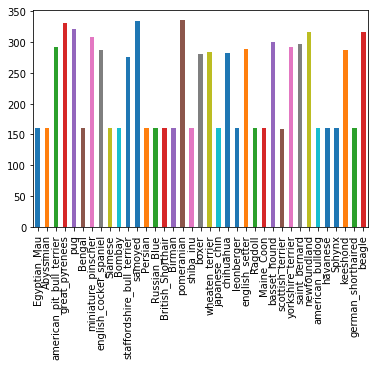

In [12]:
# plot counts of training photos
pd.Series(all_counts, name='train').plot(kind = 'bar')

Breeds that only have 160 photos were only in the Oxford dataset (for exsample all of the cat breeds as the Standord dataset only contianed pictures of dog breeds), breeds that have more where in both the Oxford and the Stanford datasets

In [0]:
# get counts for testing photos
all_counts = get_category_counts('test')

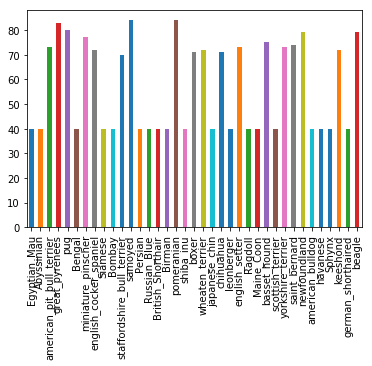

In [14]:
# plot counts of testing photos
pd.Series(all_counts, name='train').plot(kind = 'bar')

You will notice that the data is in a simular shape as the testing data, the same breeds that have 40 here had 160 there and the same ones that have more there also have the same proportion of more here.

# Set up data to run models

In [0]:
def get_train_test_images_labels(directory, test_batch_size = 32, train_batch_size = 32, target_size = (128,128)):
    '''
    Change the images into a tensor
    Rescale them so the math is easier for the RGB colors
    Make the lables for the images into a matrix
    '''
    os.chdir(directory)
    train_data_dir = 'train'
    test_data_dir = 'test'

    # get data the validation, and reshape them
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
            test_data_dir, 
            target_size=target_size, batch_size=test_batch_size) 

    # get data from the train directory and reshape them
    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
            train_data_dir, 
            target_size=target_size, batch_size= train_batch_size)

    # create the data sets
    train_images, train_labels = next(train_generator)
    test_images, test_labels = next(test_generator)
    print("train_images shape: ",train_images.shape)
    print("train_labels shape: ", train_labels.shape) 
    print("test_images shape: ", test_images.shape)
    print("test_labels shape: ", test_labels.shape)
    
    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = get_train_test_images_labels('/content/content', 2122,8457)

Found 2122 images belonging to 37 classes.
Found 8457 images belonging to 37 classes.
train_images shape:  (8457, 128, 128, 3)
train_labels shape:  (8457, 37)
test_images shape:  (2122, 128, 128, 3)
test_labels shape:  (2122, 37)


Need to reshape the data

In [4]:
def reshape_image_matrices(train_images, test_images):
    # flatten the tensors into matrices
    
    train_x = train_images.reshape(train_images.shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
    test_x = test_images.reshape(test_images.shape[0], -1)


    print ("train_x's shape: " + str(train_x.shape)) #12288 = 64*64*3 (pixels length * pix width * rgb)
    print ("test_x's shape: " + str(test_x.shape))
    return train_x, test_x
train_x, test_x = reshape_image_matrices(train_images,test_images)

train_x's shape: (8457, 49152)
test_x's shape: (2122, 49152)


In [22]:
print(train_x)

[[0.3254902  0.3372549  0.35686275 ... 0.05490196 0.09019608 0.1254902 ]
 [0.69803923 0.61960787 0.4901961  ... 0.7803922  0.7058824  0.5803922 ]
 [0.00392157 0.00392157 0.00392157 ... 0.7294118  0.7294118  0.7294118 ]
 ...
 [0.6        0.43137258 0.29803923 ... 0.34509805 0.21568629 0.08627451]
 [0.24705884 0.24705884 0.2392157  ... 0.24705884 0.24705884 0.24705884]
 [0.07450981 0.06666667 0.00784314 ... 0.45882356 0.4784314  0.25882354]]


# Run CNN

## SGD with 64 batch size

In [26]:
# set up a Sequential Keras model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(49152,))) #input shape is # of features
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(37, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
# run the model

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_x,
                    train_labels,
                    epochs=120,batch_size = 64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/120
8457/8457 [==============================] - 7s 820us/step - loss: 3.6077 - acc: 0.0449
Epoch 2/120
8457/8457 [==============================] - 6s 756us/step - loss: 3.5674 - acc: 0.0578
Epoch 3/120
8457/8457 [==============================] - 6s 752us/step - loss: 3.5306 - acc: 0.0591
Epoch 4/120
8457/8457 [==============================] - 6s 755us/step - loss: 3.4887 - acc: 0.0707
Epoch 5/120
8457/8457 [==============================] - 6s 744us/step - loss: 3.4548 - acc: 0.0748
Epoch 6/120
8457/8457 [==============================] - 7s 808us/step - loss: 3.4307 - acc: 0.0783
Epoch 7/120
8457/8457 [==============================] - 6s 731us/step - loss: 3.4102 - acc: 0.0829
Epoch 8/120
8457/8457 [==============================] - 6s 722us/step - loss: 3.3883 - acc: 0.0847
Epoch 9/120
8457/8457 [==============================] - 6s 730us/step - loss: 3.3768 - acc: 0.0906
Epoch 10/120
8457/8457 [============================

In [28]:
# lets see how the model preforms on the test data
# random guessing would be 2.7% so it does do better then that but not by much
score = model.evaluate(test_x, test_labels)
print(list(zip(model.metrics_names, score)))

2122/2122 [==============================] - 1s 313us/step
[('loss', 5.733232424463673), ('acc', 0.06267672007540057)]


## SGD with 32 batch size

In [32]:
# set up of a new sequential model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(49152,))) #input shape is # of features
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(37, activation='softmax'))

# run the new model with a smaller batch size 
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_x,
                    train_labels,
                    epochs=120,batch_size = 32)

Epoch 1/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.5785 - acc: 0.0464
Epoch 2/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.4580 - acc: 0.0753
Epoch 3/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.4071 - acc: 0.0853
Epoch 4/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.3718 - acc: 0.0882
Epoch 5/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.3391 - acc: 0.0990
Epoch 6/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.3186 - acc: 0.1037
Epoch 7/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.2920 - acc: 0.1093
Epoch 8/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.2676 - acc: 0.1120
Epoch 9/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.2488 - acc: 0.1172
Epoch 10/120
8457/8457 [==============================] - 11s 1ms/step - loss: 3.2236 - acc: 0.1212
Epoch 11/

##vgg like covnet
https://keras.io/getting-started/sequential-model-guide/

In [7]:
# This model takes FOREVER (about 3 and a half hours) to run if you are not on GPU
# Do not run unless you are on GPU

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD


x_test = test_images/255.
y_test = test_labels

model = Sequential()
# input: 64x64 images with 3 channels -> (64, 64, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(37, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.fit(train_images, train_labels, batch_size=32, epochs=10)
score = model.evaluate(test_images, test_labels, batch_size=32)

Epoch 1/10
8457/8457 [==============================] - 18s 2ms/step - loss: 3.5750 - acc: 0.0402
Epoch 2/10
8457/8457 [==============================] - 17s 2ms/step - loss: 3.4581 - acc: 0.0761
Epoch 3/10
8457/8457 [==============================] - 17s 2ms/step - loss: 3.3741 - acc: 0.0888
Epoch 4/10
8457/8457 [==============================] - 17s 2ms/step - loss: 3.2868 - acc: 0.1087
Epoch 5/10
8457/8457 [==============================] - 17s 2ms/step - loss: 3.1589 - acc: 0.1347
Epoch 6/10
8457/8457 [==============================] - 17s 2ms/step - loss: 2.9995 - acc: 0.1685
Epoch 7/10
8457/8457 [==============================] - 17s 2ms/step - loss: 2.8379 - acc: 0.2057
Epoch 8/10
8457/8457 [==============================] - 17s 2ms/step - loss: 2.5678 - acc: 0.2733
Epoch 9/10
8457/8457 [==============================] - 17s 2ms/step - loss: 2.2289 - acc: 0.3656
Epoch 10/10
2122/2122 [==============================] - 1s 693us/step


In [8]:
# lets see how the model preforms on the test data
# random guessing would be 2.7% so it does do better then that but 18% still isn't great
score = model.evaluate(test_images, test_labels)
print(score)

2122/2122 [==============================] - 1s 689us/step
[3.141008284943605, 0.1828463714039629]


## Model with Adam instead of SGD

In [38]:
# set up a Sequential Keras model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(49152,))) #input shape is # of features
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(37, activation='softmax'))

# run the model with Adam

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x,
                    train_labels,
                    epochs=120,batch_size = 64)

Epoch 1/120
8457/8457 [==============================] - 12s 1ms/step - loss: 4.0107 - acc: 0.0357
Epoch 2/120
8457/8457 [==============================] - 10s 1ms/step - loss: 3.5905 - acc: 0.0374
Epoch 3/120
8457/8457 [==============================] - 10s 1ms/step - loss: 3.5782 - acc: 0.0359
Epoch 4/120
8457/8457 [==============================] - 10s 1ms/step - loss: 3.5698 - acc: 0.0367
Epoch 5/120
8457/8457 [==============================] - 10s 1ms/step - loss: 3.5654 - acc: 0.0381
Epoch 6/120
8457/8457 [==============================] - 10s 1ms/step - loss: 3.5635 - acc: 0.0393
Epoch 7/120
8457/8457 [==============================] - 10s 1ms/step - loss: 3.5628 - acc: 0.0401
Epoch 8/120
8457/8457 [==============================] - 10s 1ms/step - loss: 3.5625 - acc: 0.0393
Epoch 9/120
8457/8457 [==============================] - 10s 1ms/step - loss: 3.5624 - acc: 0.0383
Epoch 10/120
8457/8457 [==============================] - 10s 1ms/step - loss: 3.5623 - acc: 0.0383
Epoch 11/

In [39]:
# lets see how the model does on the test day
# 3.9% is pretty terrible and barely better then random guessing
score = model.evaluate(test_x, test_labels)
print(list(zip(model.metrics_names, score)))

2122/2122 [==============================] - 2s 934us/step
[('loss', 3.5610298759863133), ('acc', 0.039585296896748896)]


# Transfer learning

most of this comes from https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e 

In [0]:
# import needed libaraies
# some of these are a repeat of ones above, but with how colabs times out I'm leaving them all here so you can run things peicemeal

import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [13]:
#imports the mobilenet model and discards the last 1000 neuron layer.
base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
#we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(37,activation='softmax')(x) #final layer with softmax activation

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 1s 0us/step


In [0]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [15]:
# look at the different layers of the model
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [0]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [17]:
# set up training data

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('/content/content/train',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)


Found 8457 images belonging to 37 classes.


In [18]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

# run model
step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
264/264 [==============================] - 56s 211ms/step - loss: 1.4257 - acc: 0.5717
Epoch 2/10
264/264 [==============================] - 50s 191ms/step - loss: 0.8799 - acc: 0.7280
Epoch 3/10
264/264 [==============================] - 50s 189ms/step - loss: 0.6609 - acc: 0.7968
Epoch 4/10
264/264 [==============================] - 49s 187ms/step - loss: 0.5305 - acc: 0.8371
Epoch 5/10
264/264 [==============================] - 49s 186ms/step - loss: 0.4575 - acc: 0.8648
Epoch 6/10
264/264 [==============================] - 49s 186ms/step - loss: 0.4169 - acc: 0.8720
Epoch 7/10
264/264 [==============================] - 50s 189ms/step - loss: 0.3615 - acc: 0.8916
Epoch 8/10
264/264 [==============================] - 49s 187ms/step - loss: 0.3506 - acc: 0.8957
Epoch 9/10
264/264 [==============================] - 50s 190ms/step - loss: 0.3124 - acc: 0.9072
Epoch 10/10
264/264 [==============================] - 49s 187ms/step 

In [23]:
# see how well the model does on test images
# 46% is way better then the CNNs from scratch 
score = model.evaluate(test_images, test_labels)
print(score)

2122/2122 [==============================] - 2s 883us/step
[3.106825522270886, 0.4641847313854854]


In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
# see how well the model does on the test images
predictions_transfer = model.predict(test_images)

In [0]:
# compare how well the model's predicted lables are to the actual lables
transfer_preds = [np.argmax(prediction) for prediction in predictions_transfer]
true_labels = [np.argmax(true_test_label) for true_test_label in test_labels]

Confusion matrix, without normalization
[[14  0  0 ...  0  1  0]
 [ 3  3  0 ...  1  2  0]
 [ 0  0  5 ...  1  0  0]
 ...
 [ 0  0  0 ... 13  6  0]
 [ 0  0  0 ...  0 48  0]
 [ 0  0  0 ...  0 23 17]]


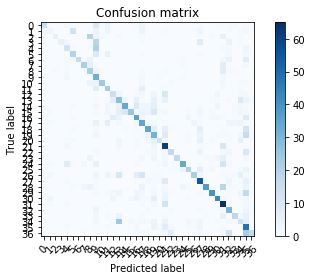

In [32]:
# plot confusion matrix
plot_confusion_matrix(confusion_matrix(true_labels, transfer_preds), range(0,37))